# Determining optimal hyperparamter configuration for regional fire frequencies 

Authors: Jatan Buch (v1, 220111) || (v2, 220118)

## 1 - Loading packages and data products

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
fire_file= data_dir + "burnarea_12km.nc"

In [3]:
fire_L3_freq_df= pd.read_hdf(data_dir + 'clim_L3_fire_freq_data.h5')
L3_weights, _= np.histogram(fire_L3_freq_df['fire_freq'], density= True, bins= [0, 1, 10, 20, 100]) 
sample_L3_weight_arr= pd.cut(fire_L3_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 10, 20, 100], \
                             labels= (L3_weights[0]/L3_weights)/np.sum(L3_weights[0]/L3_weights), include_lowest= True)
fire_L3_freq_df['sample_weight']= sample_L3_weight_arr

fire_L4_freq_df= pd.read_hdf(data_dir + 'clim_L4_fire_freq_data.h5')
L4_weights, _= np.histogram(fire_L4_freq_df['fire_freq'], density= True, bins= [0, 1, 3, 10, 50]) 
sample_L4_weight_arr= pd.cut(fire_L4_freq_df['fire_freq'].to_numpy(), bins= [0, 1, 3, 10, 50], 
                            labels= (L4_weights[0]/L4_weights)/np.sum(L4_weights[0]/L4_weights), include_lowest= True)
fire_L4_freq_df['sample_weight']= sample_L4_weight_arr
#fire_freq_L3_data= np.array(fire_freq_df[fire_freq_df['month'] >= 372].fire_freq, dtype=np.float32)

## 2 - Testing

In [4]:
X_L3_freqs_train, X_L3_freqs_val, y_L3_freqs_train, y_L3_freqs_val, fire_L3_freq_test, X_L3_freqs_test, y_L3_freqs_test, \
        L3_freq_samp_weight_arr= fire_freq_data(fire_L3_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])
X_L4_freqs_train, X_L4_freqs_val, y_L4_freqs_train, y_L4_freqs_val, fire_L4_freq_test, X_L4_freqs_test, y_L4_freqs_test, \
        L4_freq_samp_weight_arr= fire_freq_data(fire_L4_freq_df, dropcols= ['index', 'Tmin', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'Elev', 'Camp_dist'])

### 2.1 Fire frequency

In [5]:
#%time hp_df= fire_freq_predict(fire_L3_freq_df, fire_L4_freq_df, n_iters= 10, n_epochs= 500, bs= 32)
#hp_df.to_hdf('../sav_files/iter_runs_%s/'%date.today().strftime("%y_%m_%d") + 'hyperparams_iter_runs_%s.h5'%date.today().strftime("%y_%m_%d"), key= 'df', mode= 'w')

In [5]:
n_regions= 18
tot_months= 60
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
ind_grid_1= [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ind_grid_2= [[11, 12, 13], [14, 16, 18]] #, [16, 17, 18]

freqtestgrps= fire_L4_freq_test.groupby('reg_indx')
reglenarr= np.asarray([len(freqtestgrps.get_group(k)) for k in freqtestgrps.groups.keys()])
cumreglen= np.insert(np.cumsum(reglenarr), 0, 0)

freq_test_size= np.int64(len(y_L3_freqs_test)/n_regions)
freq_arr_1= np.linspace(0, len(y_L3_freqs_test) - freq_test_size, n_regions, dtype= int)
freq_arr_2= freq_arr_1 + freq_test_size

In [14]:
run_id= '22_01_17'
hp_df= pd.read_hdf('../sav_files/iter_runs_%s'%run_id + '/hyperparams_iter_runs_%s.h5'%run_id)
hp_df= hp_df[hp_df.Pearson_r >= 0.2]
hp_df['tot_metric']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq'] #hp_df['Pearson_r']*hp_df['Accuracy']
opt_freq_ind= np.asarray([hp_df.groupby('reg_indx').get_group(i+1).dropna().sort_values(by= ['tot_metric'], ascending= False).iloc[[0]].index for i in range(n_regions)]).flatten()
# hp_df['tot_metric_1']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq_2']
# hp_df['tot_metric_2']= hp_df['Emp_Accuracy']/hp_df['Red_ChiSq_1'] #/np.sqrt(hp_df['Red_ChiSq_1'])
# opt_freq_ind_1= np.asarray([hp_df.groupby('reg_indx').get_group(i).dropna().sort_values(by= ['tot_metric_1'], ascending= False).iloc[[0]].index for i in ind_grid_1.flatten()]).flatten()
# opt_freq_ind_2= np.asarray([hp_df.groupby('reg_indx').get_group(i).dropna().sort_values(by= ['tot_metric_2'], ascending= False).iloc[[0]].index for i in ind_grid_2.flatten()]).flatten()

100%|██████████| 3/3 [03:46<00:00, 75.38s/it]


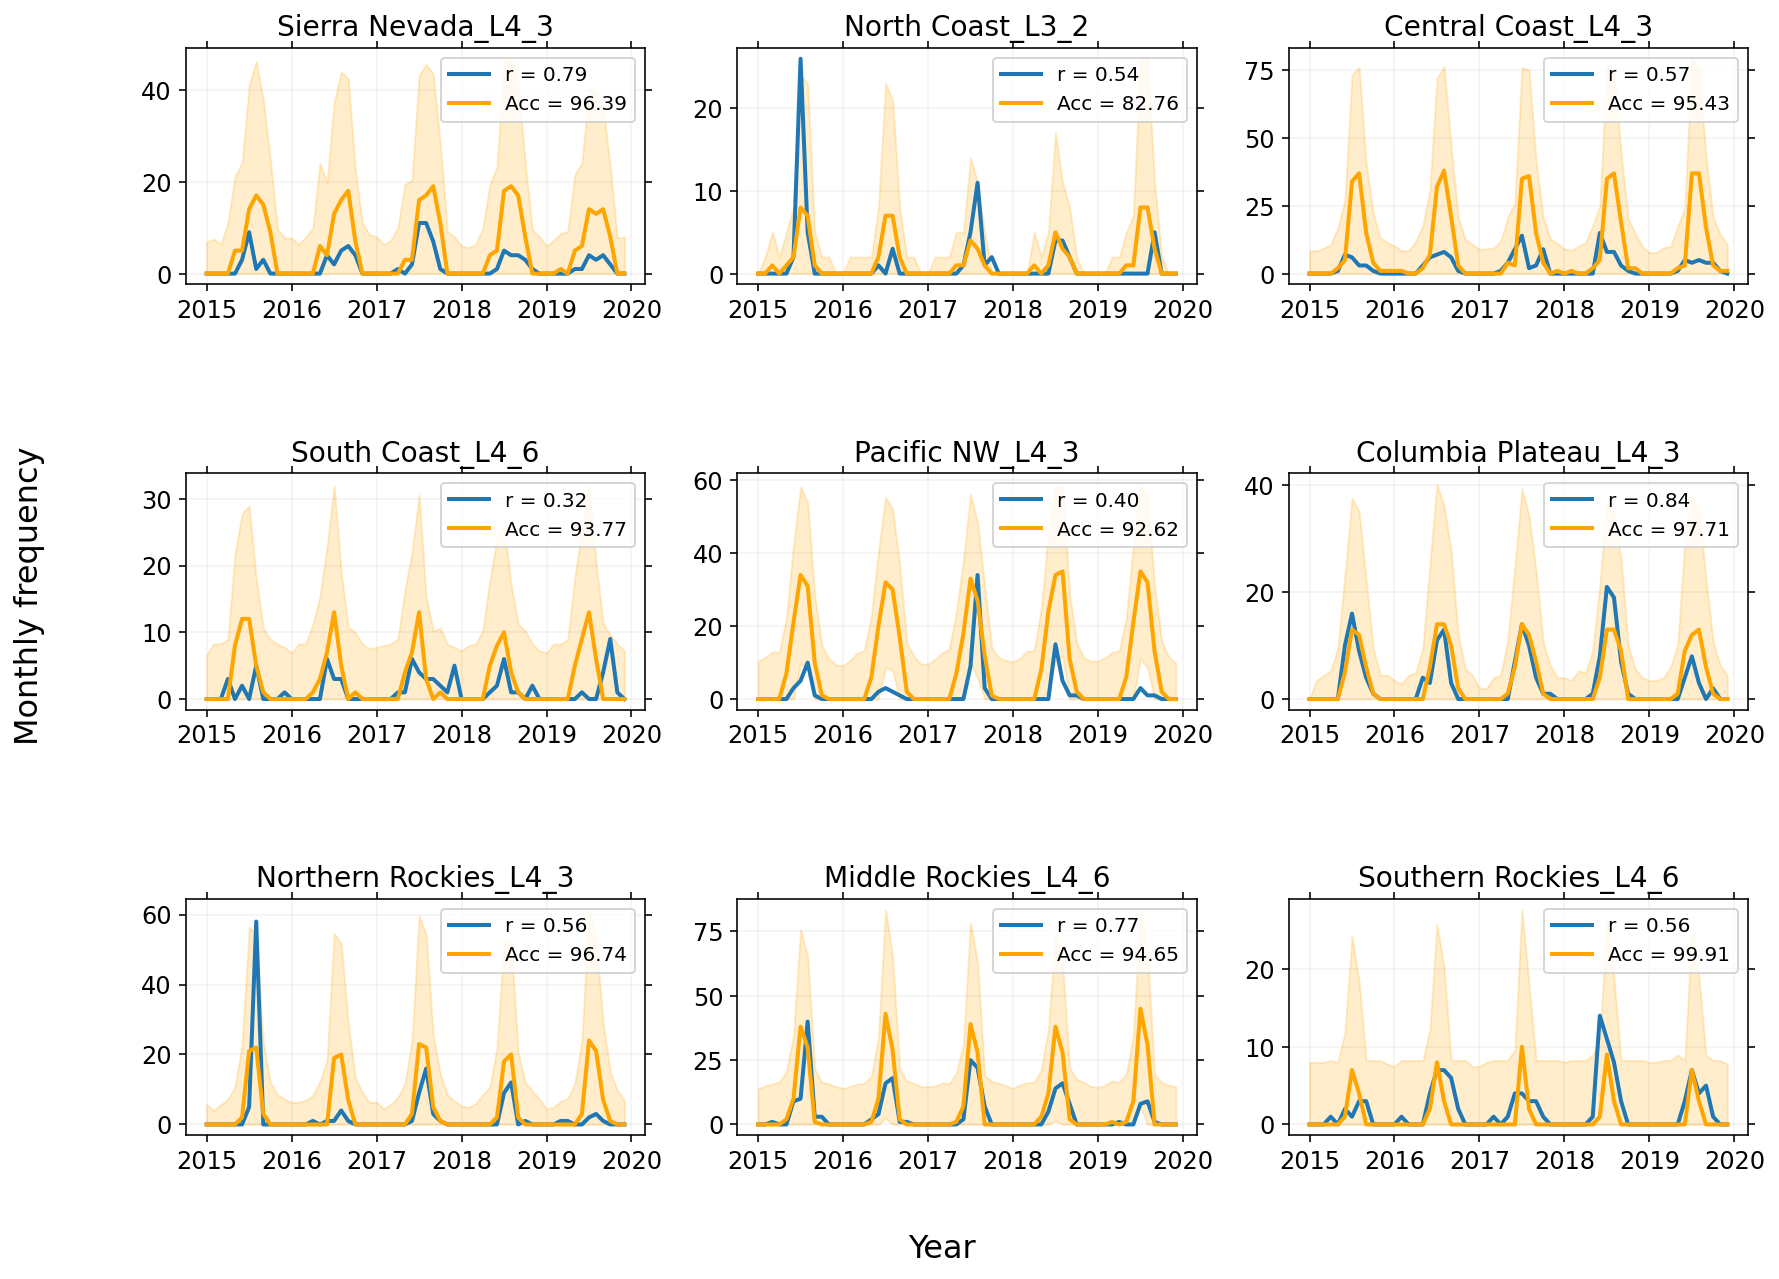

In [14]:
fig, ax= plt.subplots(3, 3, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)
regmodels= []
freqsarr= []

for i in tqdm(range(3)):
    for j in range(3):
        regindx= ind_grid_1[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zipd_model(mdn_L4_zipd.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zinb_model(mdn_L4_zinb.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            
            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0
            
            freqsarr.append(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]])
            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
                regmodels.append(zipd_model(mdn_L3_zipd.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)
                regmodels.append(zinb_model(mdn_L3_zinb.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            freqsarr.append(y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]])
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_freq_2_emp_acc_rchisq_%s.pdf'%run_id, bbox_inches='tight');

100%|██████████| 2/2 [02:29<00:00, 74.81s/it]


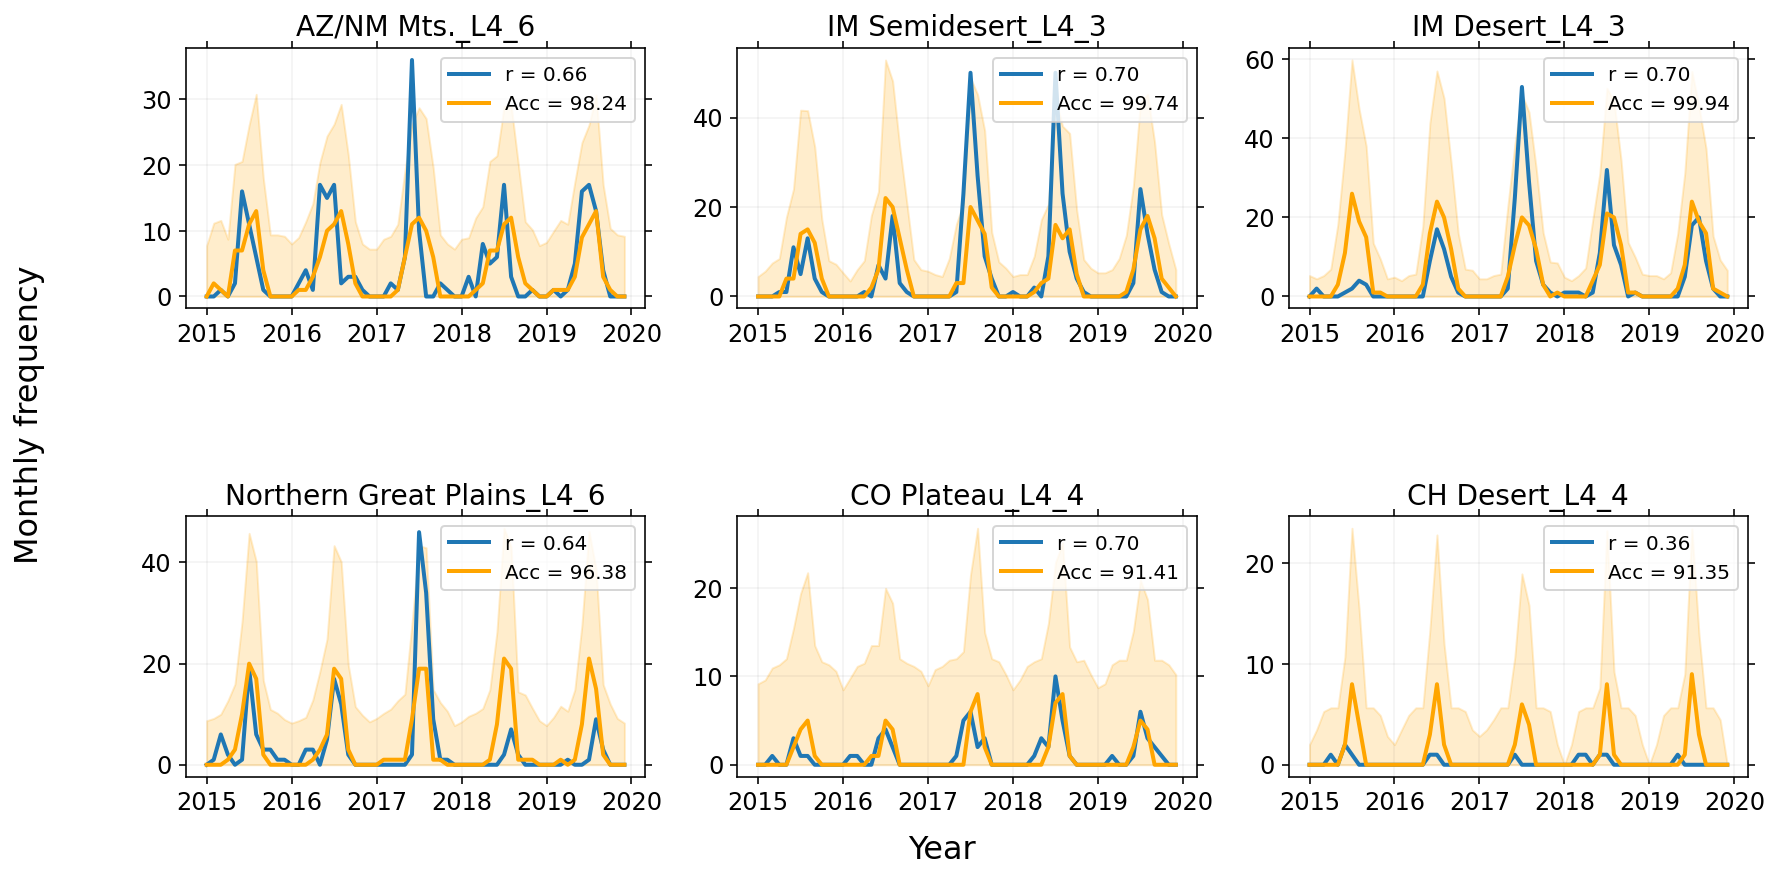

In [16]:
fig, ax= plt.subplots(2, 3, figsize=(14, 6.7))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in tqdm(range(2)):
    for j in range(3):
        regindx= ind_grid_2[i][j]
        mod_params= hp_df.loc[opt_freq_ind[regindx - 1]].to_dict()
        
        if mod_params['reg_flag'] == 'L4':
            if mod_params['func_flag'] == 'zipd':
                mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zipd_model(mdn_L4_zipd.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            else:
                mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_params['Iteration']), \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= True)
                regmodels.append(zinb_model(mdn_L4_zinb.predict(x= tf.constant(X_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]]))))
            
            reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
            fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                            for m in range(tot_months)])
            fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                                    for m in range(tot_months)])
            fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0
            
            freqsarr.append(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]])
            ax[i, j].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                for m in range(tot_months)]), lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
                   label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
        else:
            if mod_params['func_flag'] == 'zipd':
                mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= True)
                regmodels.append(zipd_model(mdn_L3_zipd.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))
            else:
                mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_params['Iteration']), \
                                                        custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
                reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= True)
                regmodels.append(zinb_model(mdn_L3_zinb.predict(x= tf.constant(X_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]]))))

            reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
            freqsarr.append(y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]])
            ax[i, j].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                                label= 'r = %.2f'%mod_params['Pearson_r']);
            ax[i, j].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                                label= 'Acc = %.2f'%mod_params['Mod_Accuracy']);
            ax[i, j].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                                     color= 'orange', alpha=0.2);

        ax[i, j].set_title('%s_'%reg_name[regindx] + '%s_'%mod_params['reg_flag'] + '%s'%mod_params['Iteration'], fontsize= 14);
        ax[i, j].set_xticks((year_arr - 2015)*12);
        ax[i, j].set_xticklabels(year_arr)
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].legend(loc='upper right', frameon= True);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_fire_freq_2_emp_acc_rchisq_%s.pdf'%run_id, bbox_inches='tight');

In [17]:
freqsarr= np.concatenate(freqsarr)
empcdf_obs= tfd.Empirical(freqsarr)
cdf_emp_obs= empcdf_obs.cdf(freqsarr)

cdf_mod= tfd.BatchConcat(regmodels, axis= 0).cdf(freqsarr)

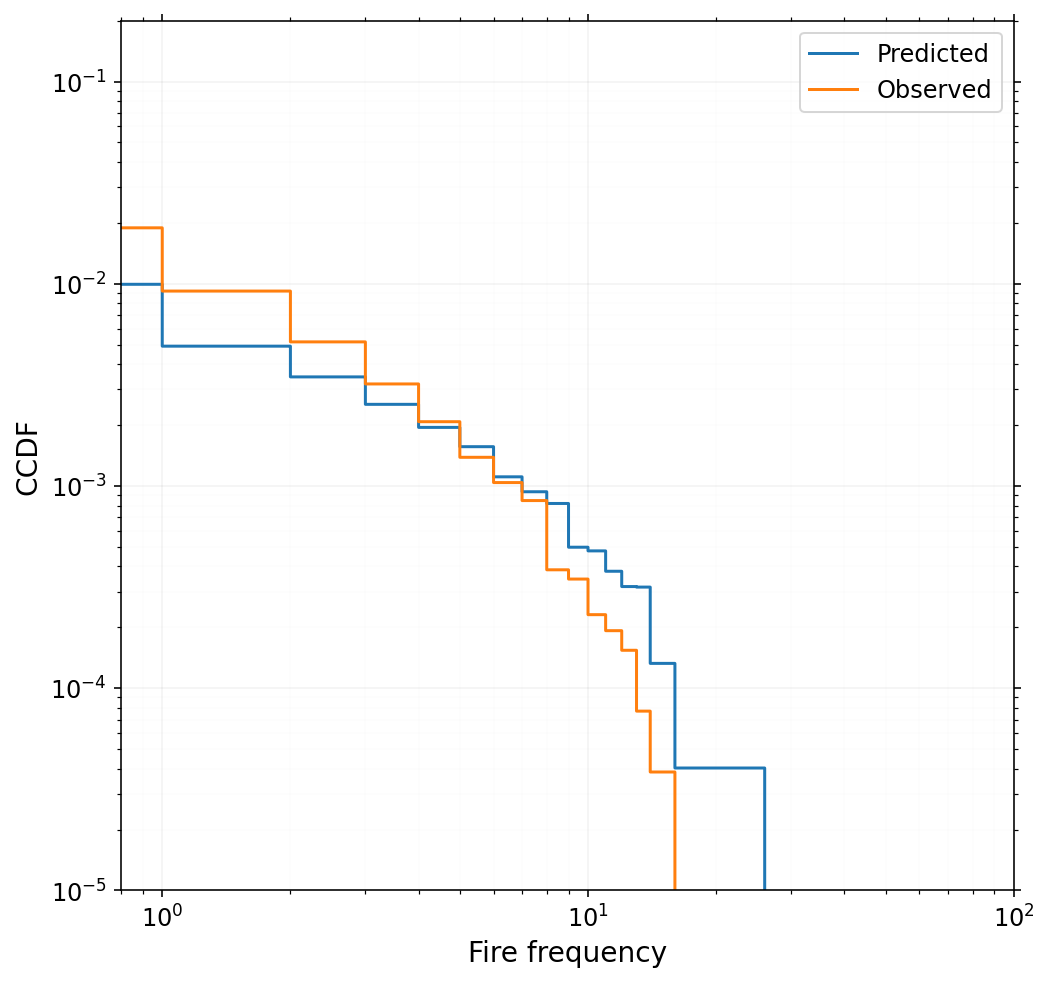

In [22]:
fig, ax= plt.subplots(figsize=(8, 8))

plt.step(np.append(np.sort(freqsarr), 30.), 1- np.append(np.sort(cdf_mod), 0.999999597), label= 'Predicted') #include linear interpolation instead
plt.step(np.sort(freqsarr), 1 - np.sort(cdf_emp_obs), label= 'Observed')

ax.set_xlabel(r'Fire frequency', fontsize= 14);
ax.set_ylabel(r'CCDF', fontsize= 14);

plt.ylim(10**-5, 0.2);
plt.xlim(0.8, 100);
plt.xscale('log')
plt.yscale('log')
plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);
#plt.savefig('../plots/fire_freq_ccdf.pdf', bbox_inches='tight');

### 2.2 Frequency LOCO analysis

In [ ]:
#run_id= '22_01_25'
#var_df= fire_freq_loco(fire_L3_freq_df, fire_L4_freq_df, n_iters= 10, n_epochs= 500, bs= 32, run_id= run_id)
#var_df.to_hdf('../sav_files/loco_runs_%s/'%run_id + 'variables_loco_runs_%s.h5'%run_id, key= 'df', mode= 'w')

In [22]:
n_regions= 18
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", 15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
varlist= np.array(['All', 'VPD', 'Tmax', 'Antprec', 'Forest', 'FFWI', 'Ant_VPD', 'Avgprec', 'Urban'])

In [23]:
run_id= '22_01_25'
var_df= pd.read_hdf('../sav_files/loco_runs_%s'%run_id + '/variables_loco_runs_%s.h5'%run_id)
var_df['tot_metric']= var_df['Emp_Accuracy']/var_df['Red_ChiSq_1'] #hp_df= hp_df.drop([2, 14, 30]) --> '22_01_24' 

In [67]:
reg_loss_arr= []
reg_argind= []
for r in tqdm(range(n_regions)):
    reg_loss= np.asarray([np.mean(var_df.groupby('reg_indx').get_group(r+1).groupby('Variable').get_group(v)['Loss'].dropna()) for v in range(len(varlist))])
    reg_argind.append(np.argsort(abs(reg_loss - reg_loss[0])/reg_loss[0])[1:])
    reg_loss_arr.append(np.sort(abs(reg_loss - reg_loss[0])/reg_loss[0])[1:])

100%|██████████| 18/18 [00:00<00:00, 63.18it/s]


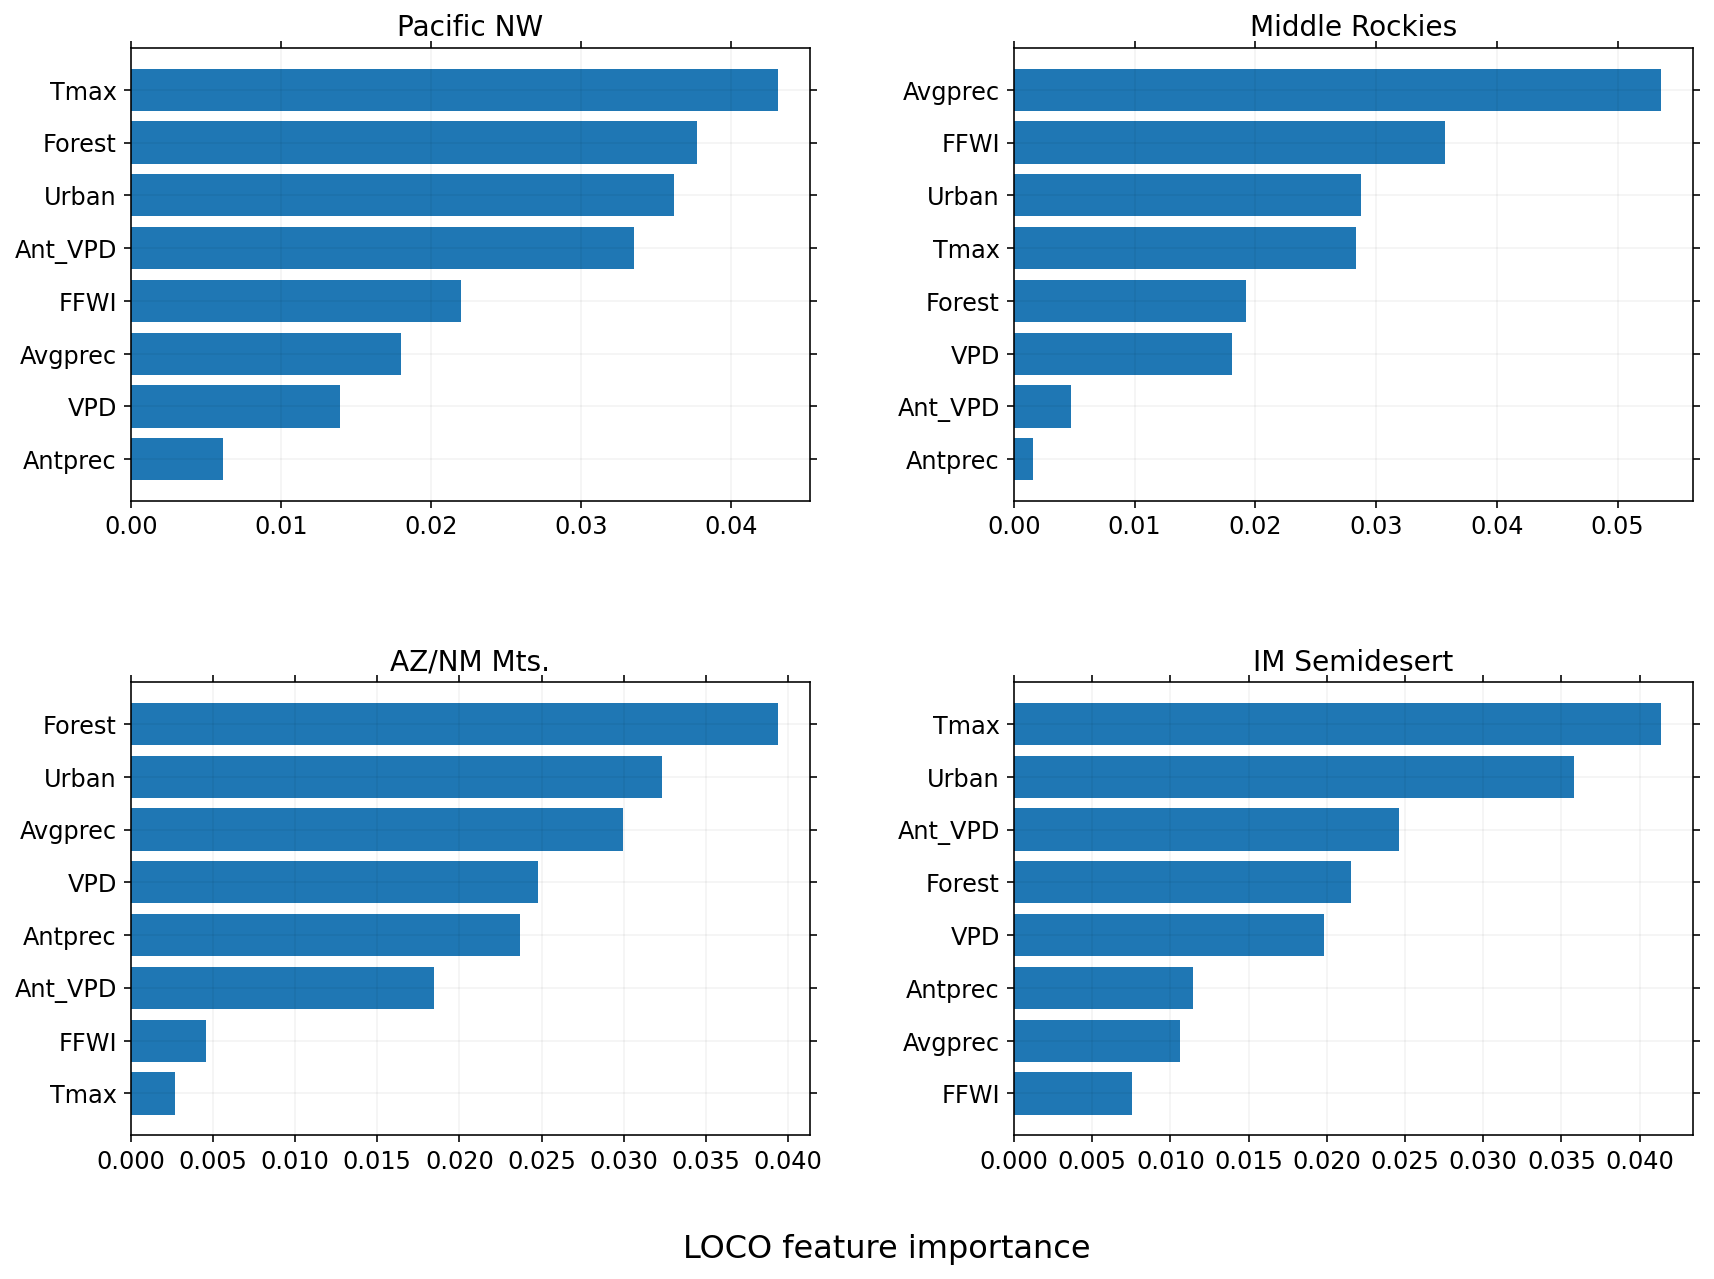

In [70]:
loco_grid= [[[1, 2], [3, 4]], [[5, 8], [11, 12]]] 

fig, ax= plt.subplots(2, 2, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
#fig.text(0.04, 0.5, r'', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'LOCO feature importance', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= loco_grid[1][i][j]
        
        ax[i, j].barh(varlist[reg_argind[regindx - 1]], reg_loss_arr[regindx - 1]);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
            
        fig.subplots_adjust(hspace= 0.4, wspace= 0.3)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/loco_fire_freq_2.pdf', bbox_inches='tight');

In [71]:
tot_avg_loss= np.asarray([np.mean([np.mean(var_df.groupby('reg_indx').get_group(r+1).groupby('Variable').get_group(v)['Loss'].dropna()) for r in range(n_regions)]) for v in range(len(varlist))])
tot_argind= np.argsort(abs(tot_avg_loss - tot_avg_loss[0]))

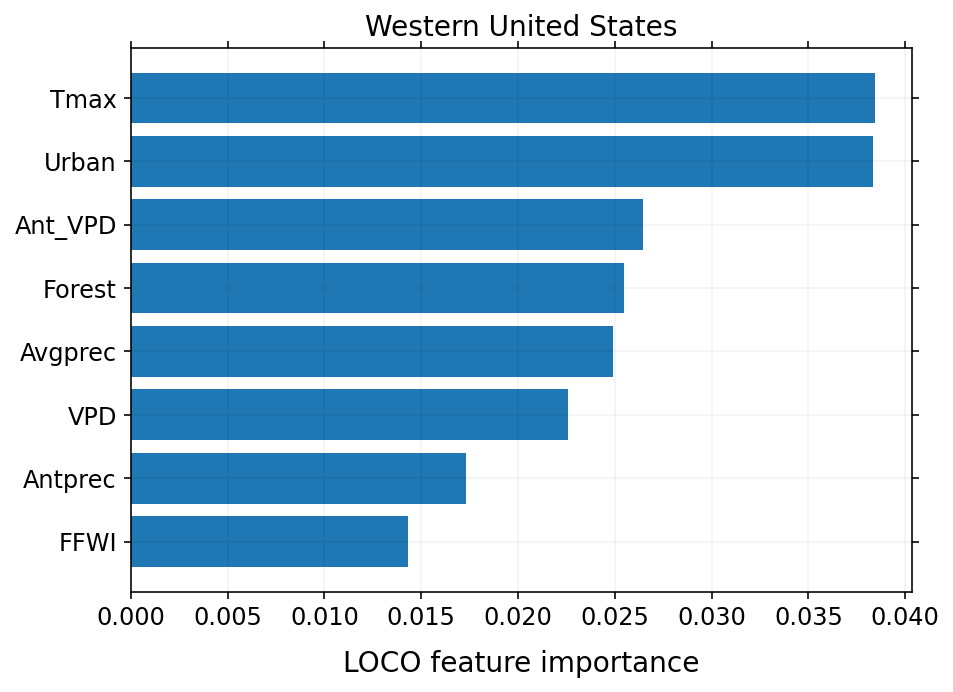

In [72]:
fig, ax= plt.subplots(1, 1, figsize=(7, 5))
ax.barh(varlist[tot_argind][1:], np.sort(abs(tot_avg_loss - tot_avg_loss[0])/tot_avg_loss[0])[1:]);
ax.set_title(r'Western United States', fontsize= 14);
ax.set_xlabel(r'LOCO feature importance', ha='center', fontsize= 14, labelpad= 10)
fig.subplots_adjust(hspace= 0.4, wspace= 0.3)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/loco_fire_freq_all.pdf', bbox_inches='tight');

## Metrics expt

In [66]:
l4_freqs= y_L4_freqs_test[cumreglen[4]:cumreglen[5]]
obs_input= X_L4_freqs_test[cumreglen[4]:cumreglen[5]]

mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_3', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
param_vec= mdn_L4_zipd.predict(x= tf.constant(obs_input))
y_L4_pred= tf.floor(tf.reduce_mean(zipd_model(param_vec).sample(10000), axis= 0))

In [77]:
l4_zinb_freqs= y_L4_freqs_test[cumreglen[5]:cumreglen[6]]
obs_zinb_input= X_L4_freqs_test[cumreglen[5]:cumreglen[6]]

mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zinb_iter_3', \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
param_zinb_vec= mdn_L4_zinb.predict(x= tf.constant(obs_zinb_input))

In [ ]:
np.histogram(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])

(array([2626,    9,    4,    0,    0,    0,    0,    0,    0,    1]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ],
       dtype=float32))

In [68]:
l4_freqs= y_L4_freqs_test[cumreglen[4]:cumreglen[5]]
obs_input= X_L4_freqs_test[cumreglen[4]:cumreglen[5]]

In [69]:
mdn_1= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L4_zipd_iter_8', \
                                                                                    custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
pvec_1= mdn_1.predict(x= tf.constant(obs_input))
y_pred_1= tf.floor(tf.reduce_mean(zipd_model(pvec_1).sample(10000), axis= 0))

In [70]:
zipd_loss(l4_freqs, pvec_1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25375062>

In [72]:
mdn_2= tf.keras.models.load_model('../sav_files/iter_runs_22_01_13/mdn_L3_zinb_iter_3', \
                                                                                    custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
pvec_2= mdn_2.predict(x= tf.constant(obs_input))
y_pred_2= tf.floor(tf.reduce_mean(zinb_model(pvec_2).sample(10000), axis= 0))

In [73]:
zinb_loss(l4_freqs, pvec_2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73745924>

In [74]:
empcdf= tfd.Empirical(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])
cdf_obs= empcdf.cdf(y_L4_freqs_test[cumreglen[4]:cumreglen[5]])

In [75]:
empcdf_1= tfd.Empirical(y_pred_1)
cdf_1= empcdf_1.cdf(y_pred_1)

empcdf_2= tfd.Empirical(y_pred_2)
cdf_2= empcdf_2.cdf(y_pred_2)

In [76]:
100 - tf.abs(100*(-tf.reduce_mean(tf.math.log(cdf_1/cdf_obs), axis= 0)))

<tf.Tensor: shape=(), dtype=float32, numpy=87.75865>

In [77]:
100 - 100*(tf.reduce_mean(tf.abs(cdf_1 - cdf_obs), axis= 0))

<tf.Tensor: shape=(), dtype=float32, numpy=88.20306>

In [78]:
100 - 100*(tf.reduce_mean(tf.abs(cdf_2 - cdf_obs), axis= 0))

<tf.Tensor: shape=(), dtype=float32, numpy=66.12222>

In [79]:
100 - tf.abs(100 *(-tf.reduce_mean(tf.math.log(cdf_2/cdf_obs), axis= 0)))

<tf.Tensor: shape=(), dtype=float32, numpy=53.50995>

In [84]:
pmf_pred_1= zipd_model(pvec_1).prob(l4_freqs)
pmf_pred_2= zinb_model(pvec_2).prob(l4_freqs)

In [85]:
pmf_obs= empcdf.prob(l4_freqs)

In [86]:
stat

0.0032069471

In [87]:
stats.entropy(pmf_obs, qk= pmf_pred_2)

0.13214958

## Sanity checks

In [131]:
hp_df.groupby('reg_indx').get_group(12).sort_values(by= ['tot_metric'], ascending= False)

,Iteration,reg_indx,reg_flag,func_flag,Pearson_r,Red_ChiSq,Accuracy,tot_metric
335,5,12,L4,zipd,0.748442,728.115094,97.023041,72.616146
191,3,12,L4,zipd,0.715239,75.691683,97.875687,70.004538
406,6,12,L4,zinb,0.709484,596.406475,96.889992,68.741912
263,4,12,L4,zipd,0.691487,429.520016,98.056702,67.804933
479,7,12,L4,zipd,0.690961,98.660700,97.518921,67.381768
119,2,12,L4,zipd,0.657508,436.789018,98.696587,64.893787
333,5,12,L3,zipd,0.697401,1007.694592,92.490280,64.502837
46,1,12,L4,zinb,0.652885,189.618130,98.719650,64.452552
261,4,12,L3,zipd,0.668481,815.996922,93.838493,62.729219
623,9,12,L4,zipd,0.638727,65.605964,97.859322,62.505355


100%|██████████| 18/18 [00:02<00:00,  7.74it/s]


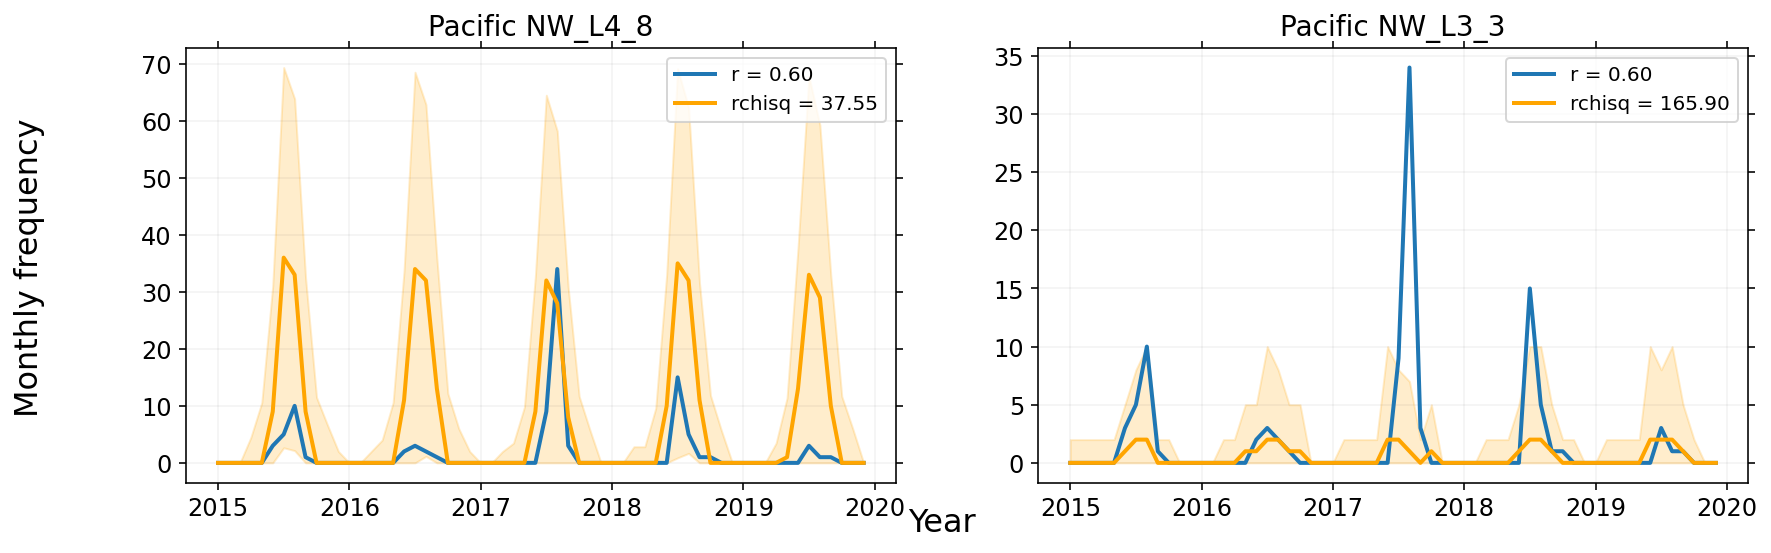

In [13]:
fig, ax= plt.subplots(1, 2, figsize=(14, 4))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Monthly frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

regindx= 5
mod_1_params= {'Iteration': 8, 'reg_flag': 'L4', 'func_flag': 'zipd', 'best_ind': 0}
mod_2_params= {'Iteration': 3, 'reg_flag': 'L3', 'func_flag': 'zinb', 'best_ind': 8}
        
if mod_1_params['reg_flag'] == 'L4':
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[0].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_1_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_1_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[0].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Pearson_r']);
    ax[0].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_1_params['best_ind']]['Red_ChiSq']);
    ax[0].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
       
ax[0].set_title('%s_'%reg_name[regindx] + '%s_'%mod_1_params['reg_flag'] + '%s'%mod_1_params['Iteration'], fontsize= 14);
ax[0].set_xticks((year_arr - 2015)*12);
ax[0].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
#fig.minorticks_on()
ax[0].legend(loc='upper right', frameon= True);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[0].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[0].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

if mod_2_params['reg_flag'] == 'L4':
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    else:
        mdn_L4_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                                            custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zinb, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)
    
    reg_L4_freq_groups= reg_L4_freq_df.groupby('reg_indx')
    fire_l3_mean_freqs= np.asarray([np.sum(reg_L4_freq_groups.get_group(regindx)['mean_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                                                                    for m in range(tot_months)])
    fire_l3_high_freqs= fire_l3_mean_freqs + 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs= fire_l3_mean_freqs - 2*np.sqrt([np.sum(reg_L4_freq_groups.get_group(regindx)['std_freq'].iloc[np.arange(m, reglenarr[regindx - 1], tot_months)]**2) \
                            for m in range(tot_months)])
    fire_l3_low_freqs[fire_l3_low_freqs < 0]= 0

    ax[1].plot(month_arr, np.asarray([np.sum(y_L4_freqs_test[cumreglen[regindx - 1]:cumreglen[regindx]][np.arange(m, reglenarr[regindx - 1], tot_months)]) \
                                        for m in range(tot_months)]), lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, fire_l3_mean_freqs, color= 'orange', lw= 2, \
           label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, fire_l3_high_freqs, fire_l3_low_freqs, color= 'orange', alpha=0.2);
else:
    if mod_2_params['func_flag'] == 'zipd':
        mdn_L3_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zipd_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zipd, X_test_dat= X_L3_freqs_test, func_flag= 'zipd', l4_flag= False, modsave= False)
    else:
        mdn_L3_zinb= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L3_zinb_iter_%d'%(mod_2_params['Iteration']), \
                                                custom_objects= {'zinb_loss': zinb_loss, 'zinb_accuracy': zinb_accuracy})
        reg_L3_freq_df= freq_pred_func(mdn_model= mdn_L3_zinb, X_test_dat= X_L3_freqs_test, func_flag= 'zinb', l4_flag= False, modsave= False)
        
    reg_L3_freq_groups= reg_L3_freq_df.groupby('reg_indx')
    ax[1].plot(month_arr, y_L3_freqs_test[freq_arr_1[regindx - 1]:freq_arr_2[regindx - 1]], lw= 2, \
                                        label= 'r = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Pearson_r']);
    ax[1].plot(month_arr, reg_L3_freq_groups.get_group(regindx)['mean_freq'], color= 'orange', lw= 2, \
                                        label= 'rchisq = %.2f'%hp_df.groupby('reg_indx').get_group(regindx).sort_values(by= ['tot_metric'], ascending= False).iloc[mod_2_params['best_ind']]['Red_ChiSq']);
    ax[1].fill_between(month_arr, reg_L3_freq_groups.get_group(regindx)['high_2sig_freq'], reg_L3_freq_groups.get_group(regindx)['low_2sig_freq'], \
                                                                                                                             color= 'orange', alpha=0.2);
    
ax[1].set_title('%s_'%reg_name[regindx] + '%s_'%mod_2_params['reg_flag'] + '%s'%mod_2_params['Iteration'], fontsize= 14);
ax[1].set_xticks((year_arr - 2015)*12);
ax[1].set_xticklabels(year_arr)
fig.subplots_adjust(hspace= 0.8)
ax[1].legend(loc='upper right', frameon= True);

ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax[1].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax[1].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/ml_L4_fire_freq_1_alt.pdf', bbox_inches='tight');

In [132]:
mdn_L4_zipd= tf.keras.models.load_model('../sav_files/iter_runs_%s'%run_id + '/mdn_L4_zipd_iter_3', \
                                                                            custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
reg_L4_freq_df= freq_pred_func(mdn_model= mdn_L4_zipd, X_test_dat= X_L4_freqs_test, func_flag= 'zipd', l4_flag= True, reg_len_arr= reglenarr, modsave= False)

100%|██████████| 18/18 [00:25<00:00,  1.42s/it]


In [138]:
reg_L4_freq_df.groupby('reg_indx').get_group(12)['mean_freq'].iloc[np.arange(30, reglenarr[11], tot_months)].to_numpy()

array([0, 1, 0, 0, 2, 4, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0])

In [139]:
y_L4_freqs_test[cumreglen[11]:cumreglen[12]][np.arange(30, reglenarr[11], tot_months)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  7.,  7.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  9.,  5.,  0.,  0.,  5.,  0.,  0.,  2.,  0.,
        0., 12.,  1.,  0.], dtype=float32)

In [ ]:
pnw_reg= bailey_ecoprovince_shp(region="pnw_mts", lflag = 'L4')
im_reg= bailey_ecoprovince_shp(region="im_semidesert", lflag = 'L4')

In [95]:
len(fire_freq_train.groupby('reg_indx').get_group(5)['fire_freq'][fire_freq_train.groupby('reg_indx').get_group(5)['fire_freq'] > 10])*100/len(fire_freq_train.groupby('reg_indx').get_group(5))

0.012218963831867057

In [77]:
len(fire_freq_train.groupby('reg_indx').get_group(5).groupby('l4_indx').groups.keys())

44

In [108]:
fire_freq_train.groupby('reg_indx').get_group(5)[fire_freq_train.groupby('reg_indx').get_group(5)['fire_freq'] > 10]

,Tmax,VPD,Prec,Antprec,Forest,Solar,Wind,Grassland,Elev,RH,...,FFWI,Tmin,Camp_dist,Camp_num,Road_dist,fire_freq,month,reg_indx,l4_indx,sample_weight
52674,29.204813,15.007778,3.075185,56.521782,0.848772,337.811859,2.965555,0.024447,1134.031128,47.061108,...,11.612963,11.242222,6.774000,6.631889,13.838964,11,222,5,4f,0.007013
54355,29.254526,15.389285,2.938571,72.961365,0.875263,307.435699,2.695714,0.061837,730.947632,47.437378,...,10.181666,11.489524,9.308763,3.289405,13.641286,14,43,5,78e,0.007013


In [103]:
pnw_reg.groupby('US_L4CODE').get_group('4f').geometry.area/1e6

4915    3665.079169
dtype: float64

In [101]:
fire_freq_train.groupby('reg_indx').get_group(12)[fire_freq_train.groupby('reg_indx').get_group(12)['fire_freq'] > 10]['l4_indx'].unique()

array(['12g', '12h', '12j', '80a', '80b', '80g'], dtype=object)

In [96]:
len(fire_freq_train.groupby('reg_indx').get_group(12)['fire_freq'][fire_freq_train.groupby('reg_indx').get_group(12)['fire_freq'] > 10])*100/len(fire_freq_train.groupby('reg_indx').get_group(12))

0.26881720430107525

In [114]:
fire_freq_train.groupby('reg_indx').get_group(12)[fire_freq_train.groupby('reg_indx').get_group(12)['fire_freq'] > 10].groupby('l4_indx').get_group('80a')

,Tmax,VPD,Prec,Antprec,Forest,Solar,Wind,Grassland,Elev,RH,...,FFWI,Tmin,Camp_dist,Camp_num,Road_dist,fire_freq,month,reg_indx,l4_indx,sample_weight
129846,31.890129,22.984531,19.194445,38.724304,0.002446,305.657288,4.391282,0.134942,1572.833374,27.046324,...,19.403206,13.378718,38.968143,0.138269,45.228065,42,18,12,80a,0.992388
129859,31.074144,21.784018,5.050855,27.749054,0.002446,271.200592,4.190128,0.134942,1572.833374,26.508417,...,18.378933,11.833375,38.968143,0.138269,45.228065,14,31,12,80a,0.007013
129966,28.642820,16.879274,17.591284,22.876844,0.004919,315.891602,4.953504,0.159229,1572.833374,35.748207,...,21.678247,10.155171,38.968143,0.138269,45.228065,11,138,12,80a,0.007013
129979,30.148888,20.736452,4.277906,27.674347,0.005743,277.367584,4.297009,0.167325,1572.833374,24.813375,...,18.482777,10.082821,38.968143,0.138269,45.228065,12,151,12,80a,0.007013
130015,29.226238,19.095598,7.021923,31.517145,0.008216,272.957947,4.856966,0.191613,1572.833374,28.796495,...,18.331367,10.542223,38.968143,0.138269,45.228065,20,187,12,80a,0.007013
130110,33.846581,27.105772,7.247351,32.437614,0.009744,309.656799,3.994530,0.242304,1572.833374,21.492138,...,18.980556,14.494700,38.968143,0.138269,45.228065,23,282,12,80a,0.992388
130159,31.251282,22.629059,3.253419,28.500591,0.009646,280.498199,3.944701,0.276484,1572.833374,23.219147,...,18.328077,11.337905,38.968143,0.138269,45.228065,11,331,12,80a,0.007013
130170,32.293159,24.188633,10.332693,31.715246,0.009565,313.793243,4.163333,0.304349,1572.833374,23.732481,...,18.499615,13.095342,38.968143,0.138269,45.228065,11,342,12,80a,0.007013
130171,32.017818,24.304230,5.873163,31.715246,0.009565,277.414124,3.929274,0.304349,1572.833374,20.819017,...,18.545042,11.999914,38.968143,0.138269,45.228065,11,343,12,80a,0.007013
130182,33.280853,26.288761,14.586068,23.853273,0.009483,312.949066,4.509615,0.332214,1572.833374,21.385256,...,20.017735,13.913206,38.968143,0.138269,45.228065,14,354,12,80a,0.007013


In [105]:
np.sum(im_reg.groupby('US_L4CODE').get_group('12g').geometry.area/1e6)

16643.756604171736

In [115]:
len(fire_freq_train[fire_freq_train['fire_freq'] > 10])*100/len(fire_freq_train)

0.04281564342698578

In [155]:
np.histogram(fire_L4_freq_df['fire_freq'], density= True, bins= [0, 1, 3, 10, 50])

(array([9.52392286e-01, 2.01589568e-02, 9.70062084e-04, 1.24841323e-05]),
 array([ 0,  1,  3, 10, 50]))